# Overview

In this notebook we tried to find a sufficent enough solution for the **Curve-Fitting** problem using genetic or memtic algorithems. 
Here we describe shortly the following concepts in a genetic algorithems that we used in this notebook

### 1. Gene
We used an array of real values in range [0, 1] to mimic the coefficents of the polynomial.

### 2. Initial population
We used random values uniformly distributed in range [0, 1] for each coefficent

### 3. Fitness finction
There are various ways to define a fitness function for this problem like ***MSE*** or ***MAE***, here we decided to use ***MSE***.

$ MSE(gene) = \sqrt{\sum_{1}^{n}(\hat{y} - y)^2} $

### 4. Mutation
The mutation is simply changing each coefficient to a random number in range [0, 1] if the random probability fits the alpha parameter.

### 5. crossover
The crossover is some kind of weghited sum of both parents, with their weight distribution being a random number `w` which gives more exploration ability to the algorithem.

### 6. Local search
The local seach is run for `20` iterations and it simply searches near every coefficent by adding a noise to it around [-0.1, +0.1] of its original and picks the best answer.

### 7. Other
The other parts that are of less importance are shown using comments in the code like the selection method or recombination.

# Setup

In [44]:
import random
import numpy as np
import pandas as pd
import math

# Import Data

In [2]:
tstcase = pd.read_csv("CurveFitting-Tests/CurveFitting_test1.txt")
n = int(tstcase.iloc[0, 0])
s, e = map(int, tstcase.iloc[1, 0].split())
m = int(tstcase.iloc[2, 0])
points = []
for i in range(m) : 
    pt = list(map(float, tstcase.iloc[3 + i, 0].split()))
    points.append(pt)

In [3]:
def testcase(id) : 
    tstcase = pd.read_csv("CurveFitting-Tests/CurveFitting_test" + str(id) + ".txt")
    n = int(tstcase.iloc[0, 0])
    s, e = map(int, tstcase.iloc[1, 0].split())
    m = int(tstcase.iloc[2, 0])
    points = []
    for i in range(m) : 
        pt = list(map(float, tstcase.iloc[3 + i, 0].split()))
        points.append(pt)

    return n, s, e, m, points

# Gene

In [53]:
class Gene() : 

    def __init__(self, n, s, e, pts) : 
        self.n = n
        self.s = s
        self.e = e
        self.points = pts

        self.poly = [random.uniform(self.s, self.e) for i in range(self.n)]
        self.fitness = self.cal_fitness()

    def calc(self, x) : 
        res = 0
        for i in range(self.n) :
            res += self.poly[i] * (x**i)
        
        return res

    def dist(self, pt) : 
        return (self.calc(pt[0]) - pt[1])**2

    def cal_fitness(self) : 
        fit = 0
        for pt in self.points :
            fit += self.dist(pt)
        
        self.fitness = math.sqrt(fit)
        return self.fitness

    def mutation(self, alpha = 0.15) : 
        for i in range(self.n) :
            p = random.random()
            if(p > alpha) : 
                continue
            
            self.poly[i] = random.uniform(self.s, self.e)
        
        self.cal_fitness()

    def local_search(self, iter = 20) : 
        for _ in range(iter) : 
            temp = Gene(self.n, self.s, self.e, self.points)
            temp.poly = self.poly.copy()

            noise = random.random() - 0.5
            for i in range(self.n) : 
                temp.poly[i] += temp.poly[i] * noise * 0.2
            
            temp.cal_fitness()
            if(temp.fitness > self.fitness) : 
                self.poly = temp.poly
                self.fitness = temp.fitness
                

# Crossover

In [46]:
def crossover(par1 : Gene, par2 : Gene, itr = 5) -> Gene : 
    bst_child = Gene(par1.n, par1.s, par1.e, points)
    bst_child.fitness = 0

    for _ in range(itr) : 
        child = Gene(par1.n, par1.s, par1.e, points)
        for i in range(par1.n) :
            w = random.random()
            child.poly[i] = w * par1.poly[i] + (1 - w) * par2.poly[i]
            
        child.cal_fitness()
        if(bst_child.fitness < child.fitness) :
            bst_child = child
    
    return bst_child

# Genetic Algorithem

In [39]:
def genetic_algorithem(iterations, pop_size, n, s, e, points, alpha = 0.2, is_memtic = False) :
    # alpha = 1/n

    # first population
    # --------------------------------
    population = [Gene(n, s, e, points) for _ in range(pop_size)]
    population.sort(key = lambda x : x.fitness, reverse = False)
    # --------------------------------

    for _ in range(iterations) :
        children = []

        # selection
        # --------------------------------
        for __ in range(pop_size // 2) : 
            parents = random.choices(population, k = 2, weights = [1/(gene.fitness+1) for gene in population])

            # parents = random.choices(population, k = 3, weights = [1 for i in range(len(population))])
            # parents.sort(key = lambda x : x.fitness, reverse = False)
            # parents = parents[:2]
            # parents = random.choices(population, k = 2, weights = [(pop_size - i)/(pop_size*(pop_size + 1)/2) for i in range(pop_size)])

            # crossover
            # --------------------------------
            child = crossover(*parents)
            # --------------------------------

            # mutation
            # --------------------------------
            child.mutation(alpha)
            # --------------------------------

            children.append(child)    
        # --------------------------------

        # local search (Memtic Algorithem)
        # --------------------------------
        if is_memtic : 
            for i in range(len(children) // 2) : 
                children[i].local_search()
        # --------------------------------

        # replacement
        # --------------------------------
        population = population + children
        population.sort(key = lambda x : x.fitness, reverse = False)
        population = population[:pop_size]
        # --------------------------------

        if(_ % 50 == 0) : 
            print('best_fitness:' , population[0].fitness)

        # exit strategy
        # --------------------------------

        # --------------------------------
    
    return population[0]

# Plot solution

In [40]:
from matplotlib import pyplot as plt

In [41]:
def draw_solution(gene, points) : 
    X = []
    Y = []
    for i in range(m) : 
        X.append(points[i][0])
        Y.append(points[i][1])

    x = np.linspace(min(X) - 1, max(X) + 1, 100)
    plt.plot(x, gene.calc(x), color = 'blue')

    plt.plot(X, Y, 'ro')
    plt.show()

# Testcase #1

In [42]:
n, s, e, m, points = testcase(1)

best_fitness: 39164145317.512146
best_fitness: 1808932626.5704978
best_fitness: 409817563.23133844
best_fitness: 144853230.40953356
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966
best_fitness: 131363532.10578966


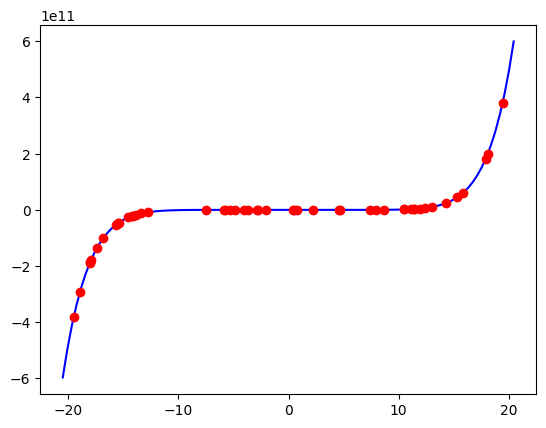

In [50]:
sol = genetic_algorithem(501, 100, n, s, e, points, is_memtic= True)
draw_solution(sol, points)

# Testcase #2

In [51]:
n, s, e, m, points = testcase(2)

best_fitness: 9991515427500.26
best_fitness: 418778890282.30396
best_fitness: 353594726538.70105
best_fitness: 351532740101.6754
best_fitness: 350245340663.3252
best_fitness: 350245340663.3252
best_fitness: 350245340663.3252
best_fitness: 350245340663.3252
best_fitness: 350245340663.3252
best_fitness: 350245340663.3252
best_fitness: 349359930113.1514


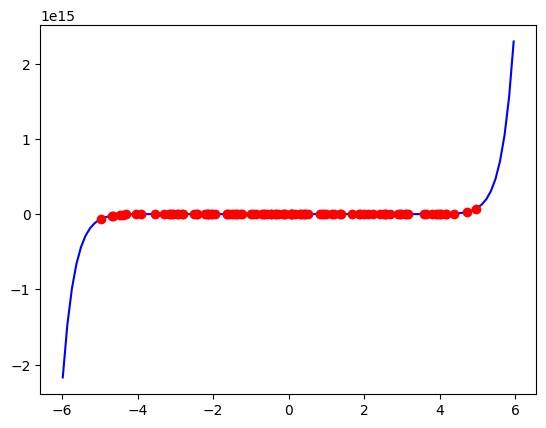

In [52]:
sol2 = genetic_algorithem(501, 100, n, s, e, points, is_memtic= True)
draw_solution(sol2, points)

# Testcase #3

In [54]:
n, s, e, m, points = testcase(3)

best_fitness: 4.1455575372674274e+32
best_fitness: 8.815767444330794e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.418704228159878e+30
best_fitness: 8.401604193586916e+30
best_fitness: 8.401604193586916e+30


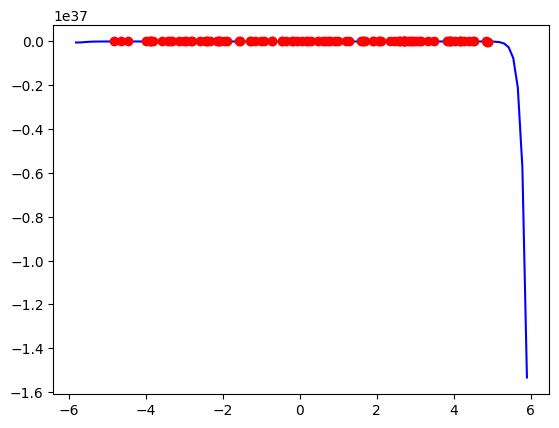

In [55]:
sol3 = genetic_algorithem(501, 100, n, s, e, points, is_memtic= True)
draw_solution(sol3, points)

# Testcase #4

In [56]:
n, s, e, m, points = testcase(4)

best_fitness: 196562286.09913516
best_fitness: 37972510.0070394
best_fitness: 6493932.96441194
best_fitness: 4015197.8197474605
best_fitness: 3512343.3647045973
best_fitness: 3318976.9074865836
best_fitness: 3286729.6072279606
best_fitness: 3159866.051827037
best_fitness: 3140237.1542651495
best_fitness: 3135924.9581477945
best_fitness: 3132134.1720241867


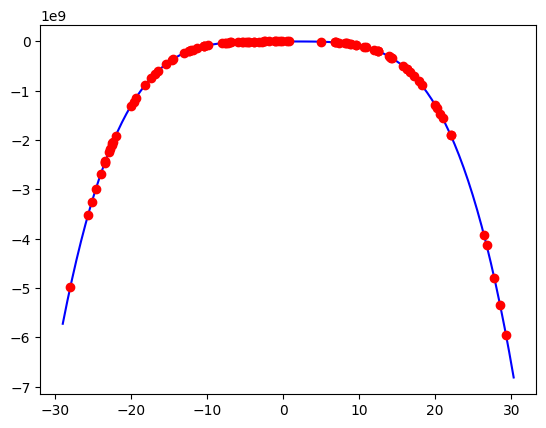

In [58]:
sol4 = genetic_algorithem(501, 100, n, s, e, points, is_memtic= True)
draw_solution(sol4, points)